<a href="https://colab.research.google.com/github/magladko/NAI/blob/master/mpp4/mpp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#K-means – NAI mini-project
###*Kornel Gładkowski @s22411*

##Import libs, mount Google Drive & set project PATH

In [750]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# from google.colab import drive
# drive.mount('/content/drive')

# !git clone https://github.com/magladko/NAI.git

##Util functions

In [751]:
def calculate_centroid(df: pd.DataFrame, cluster_id: int):
    length = len(df.loc[df["cluster"] == cluster_id])
    if length == 0:
        return None
    res = df.loc[df["cluster"] == cluster_id].iloc[:, 1:-k-1].sum(axis=0)/length
    return res

def get_dist_sq(points: pd.DataFrame, centroid: pd.Series):
    res = (points.subtract(centroid)**2)
    res["sum"] = res.sum(axis=1)
    return res["sum"]

##Set user input

- raw path iris: https://raw.githubusercontent.com/magladko/NAI/master/mpp4/data/iris_all.csv

- raw path dane_testowe.csv: https://raw.githubusercontent.com/magladko/NAI/master/mpp4/data/dane_testowe.csv

In [752]:
#@title Enter number of class { run: "auto", display-mode: "form" }
k = 3 #@param {type:"slider", min:1, max:10, step:1}
DATA_PATH = "https://raw.githubusercontent.com/magladko/NAI/master/mpp4/data/iris_all.csv" #@param {type:"string"}


##Initialize data
Read data & assign random cluster to observation

In [753]:
base_df = pd.read_csv(DATA_PATH) #  + "iris_all.csv"
train_df = base_df.iloc[:, :-1]

train_df['cluster'] = np.random.randint(1, k+1, train_df.shape[0])

# assign random values until all possibles values have assigned observation
while not np.all(np.isin([i for i in range(1, k+1)] ,train_df['cluster'].unique())):
    train_df['cluster'] = np.random.randint(1, k+1, train_df.shape[0])

# initialize distances from clusters
for i in range(1, k+1):
    train_df[i] = np.NaN

# initialize centroids of clusters
centroids = pd.DataFrame(columns=train_df.iloc[:, 1: -k-1].columns)

for i in range(1, k+1):
    temp = calculate_centroid(train_df, i)
    centroids.loc[i] = temp if temp is not None else pd.Series([np.NaN]*k)

print("cluster centroids:")
print(centroids, end='\n\n')
train_df

cluster centroids:
   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width
1      5.861364     3.000000      3.825000     1.254545
2      5.675439     3.066667      3.540351     1.070175
3      6.022449     3.097959      3.951020     1.300000



,nr,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster,1,2,3
0,4,4.6,3.1,1.5,0.2,3,NaN,NaN,NaN
1,5,5.0,3.6,1.4,0.2,1,NaN,NaN,NaN
2,10,4.9,3.1,1.5,0.1,2,NaN,NaN,NaN
3,11,5.4,3.7,1.5,0.2,2,NaN,NaN,NaN
4,16,5.7,4.4,1.5,0.4,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
145,144,6.8,3.2,5.9,2.3,3,NaN,NaN,NaN
146,145,6.7,3.3,5.7,2.5,3,NaN,NaN,NaN
147,146,6.7,3.0,5.2,2.3,1,NaN,NaN,NaN
148,147,6.3,2.5,5.0,1.9,3,NaN,NaN,NaN


###Initial state plot

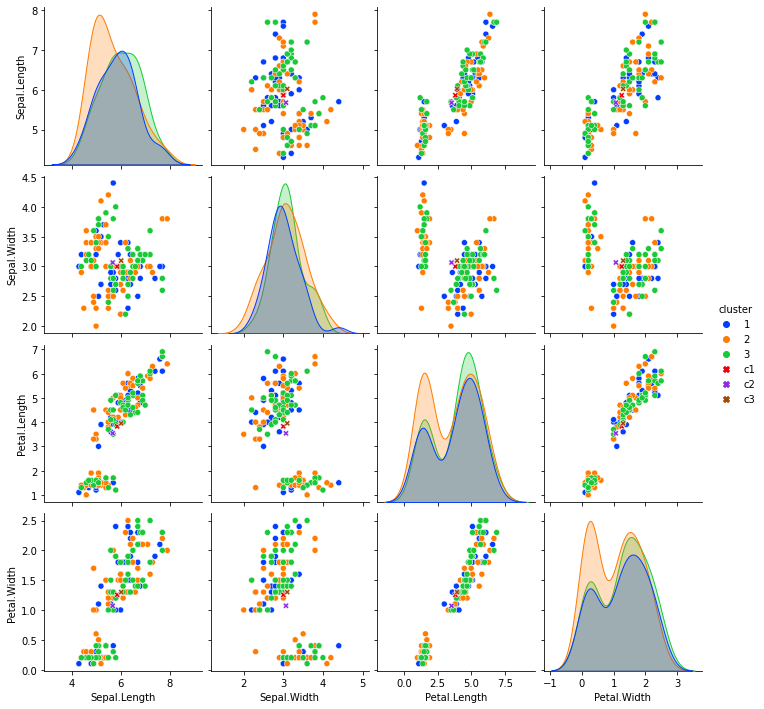

In [754]:
# adjust centroids DFs for plotting
centroids2 = centroids.reset_index()
centroids2.rename(columns={"index" : "cluster"}, inplace=True)
centroids2["cluster"] = centroids2["cluster"].apply(lambda cluster: f"c{cluster}")

# plot data with centroids
sns.pairplot(train_df.iloc[:, 1:-k].sort_values("cluster").append(centroids2, ignore_index=True), 
             hue='cluster', 
             markers=(["o"]*k)+(["X"]*k),
             palette=sns.color_palette("bright", k+k))

##Adjust clusters' centroids until nothing changes

In [755]:
distances_df = pd.DataFrame(data=np.NaN, index=list(range(1, k+1)), columns=['distance_sq','cluster_size'])
iterations = 0
any_distance_changed = True
while any_distance_changed:
    any_distance_changed = False
    
    for i in range(1, k+1):   
        temp = calculate_centroid(train_df, i)
        if temp is not None:
            centroids.loc[i] = temp

    for i in range(1, k+1):
        dist = get_dist_sq(train_df.iloc[:, 1:-k-1], centroids.loc[i])
        dist_with_cluster = train_df.join(dist).loc[:, ['cluster', 'sum']]

        distances_df.loc[i]['distance_sq'] = dist_with_cluster[dist_with_cluster['cluster']==i]['sum'].sum()
        distances_df.loc[i]['cluster_size'] = len(dist_with_cluster[dist_with_cluster['cluster']==i])

        if not train_df[i].equals(dist):
            # print(dist)
            train_df[i] = dist
            any_distance_changed = True
    
    train_df["cluster"] = train_df.iloc[:, -k:].idxmin(axis=1)
    iterations += 1
    print("iteration:", iterations)
    print(distances_df, end='\n\n')

print()
print("total iterations:", iterations)
print("centroids:")
print(centroids)
train_df

iteration: 1
   distance_sq  cluster_size
1   191.095909          44.0
2   274.408772          57.0
3   206.137551          49.0

iteration: 2
   distance_sq  cluster_size
1     3.123529          17.0
2    50.461053          57.0
3    71.376184          76.0

iteration: 3
   distance_sq  cluster_size
1    15.635000          36.0
2    15.151000          50.0
3    53.952813          64.0

iteration: 4
   distance_sq  cluster_size
1    19.570250          40.0
2    15.151000          50.0
3    49.034167          60.0

iteration: 5
   distance_sq  cluster_size
1    24.478667          45.0
2    15.151000          50.0
3    42.936364          55.0

iteration: 6
   distance_sq  cluster_size
1    27.619184          49.0
2    15.151000          50.0
3    38.746275          51.0

iteration: 7
   distance_sq  cluster_size
1    31.594259          54.0
2    15.151000          50.0
3    33.481087          46.0

iteration: 8
   distance_sq  cluster_size
1    34.127368          57.0
2    15.151000     

,nr,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,cluster,1,2,3
0,4,4.6,3.1,1.5,0.2,2,11.643921,0.27598,26.286568
1,5,5.0,3.6,1.4,0.2,2,11.973757,0.03558,25.769645
2,10,4.9,3.1,1.5,0.1,2,11.220642,0.14158,25.405030
3,11,5.4,3.7,1.5,0.2,2,11.020970,0.23278,23.708107
4,16,5.7,4.4,1.5,0.4,2,12.199659,1.45158,23.586568
...,...,...,...,...,...,...,...,...,...
145,144,6.8,3.2,5.9,2.3,3,4.084249,27.18518,0.112722
146,145,6.7,3.3,5.7,2.5,3,3.834413,25.92718,0.272722
147,146,6.7,3.0,5.2,2.3,3,2.141298,21.24438,0.355799
148,147,6.3,2.5,5.0,1.9,1,0.822118,17.78878,1.175030


###Final state plot

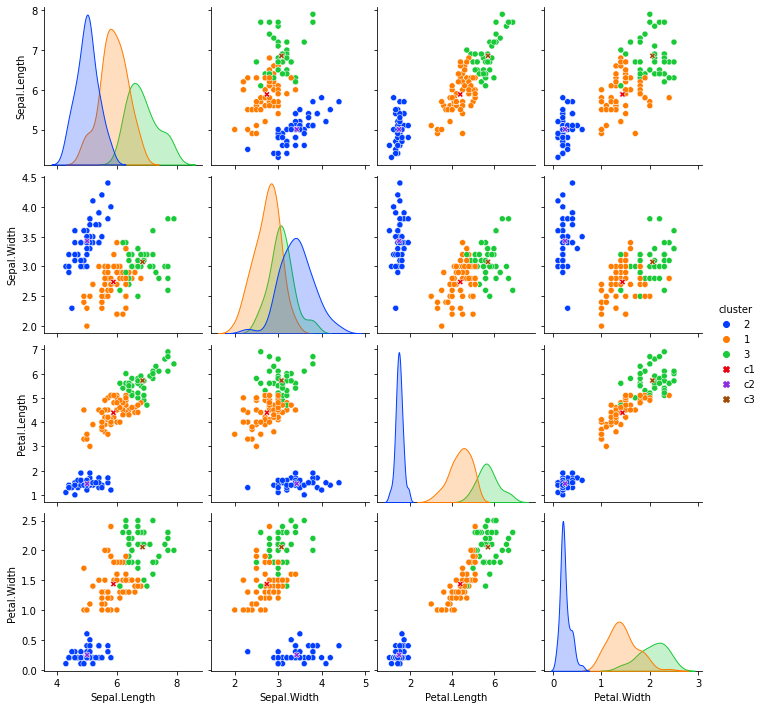

In [756]:
# adjust centroids DFs for plotting
centroids2 = centroids.reset_index()
centroids2.rename(columns={"index" : "cluster"}, inplace=True)
centroids2["cluster"] = centroids2["cluster"].apply(lambda cluster: f"c{cluster}")

not_empty_cluster_count = len(train_df["cluster"].unique())

# plot data with centroids
sns.pairplot(train_df.iloc[:, 1:-k].append(centroids2, ignore_index=True), 
             hue='cluster',
             markers=["o"]*not_empty_cluster_count+(["X"]*k),
             palette=sns.color_palette("bright", not_empty_cluster_count+k))

##Percentage of classes in clusters

In [757]:
answer_df = base_df.iloc[:, [0, -1]]
answer_df = pd.merge(answer_df, train_df.iloc[:, [0, -k-1]], on=answer_df.columns[0])

percent_df = answer_df.groupby(['cluster', answer_df.columns[1]]).count().groupby(level=0).transform(lambda x: (x / x.sum() * 100).round(2))
percent_df.rename(columns={"nr": "%"}, inplace=True)
percent_df

%
cluster Species           
1       versicolor   77.05
        virginica    22.95
2       setosa      100.00
3       versicolor    7.69
        virginica    92.31